### **CycleGAN**

**Importing Libraries**

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import Dataset
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm
from IPython import display
from PIL import Image
import os
import pandas as pd
import glob
import random

**[Dataset](https://drive.google.com/drive/folders/1sQmAlteOtIQV_mg2meP25xe34NO3YTTm?usp=sharing)**

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


(256, 256, 3)


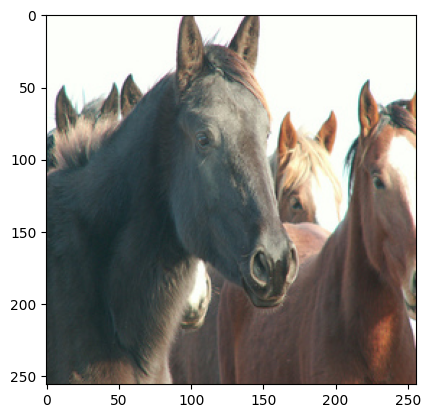

In [ ]:
# See the original size of the images
img = Image.open("/content/drive/MyDrive/horse_zebra/trainA/n02381460_1001.jpg")
print(np.array(img).shape)
plt.imshow(img);

In [ ]:
# Parameters
crop_shape = 286
original_shape = 256
h_channels = 3
z_channels = 3
batch_size = 16
device = "cuda"
lr = 2e-4
betas = (0.5, 0.999)

In [ ]:
# Custom class to load the images

class ImageDataset(Dataset):
  def __init__(self, root, transform=None, mode="train"):
    self.transform = transform
    self.files_A = sorted(glob.glob(os.path.join(root, "%sA" % mode) + "/*.*"))
    self.files_B = sorted(glob.glob(os.path.join(root, "%sB" % mode) + "/*.*"))
    if len(self.files_A) > len(self.files_B):
      self.files_A, self.files_B = self.files_B, self.files_A
    self.new_perm()

  def new_perm(self):
    self.randperm = torch.randperm(len(self.files_B))[:len(self.files_A)]

  def __getitem__(self, index):
    item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))
    item_B = self.transform(Image.open(self.files_B[self.randperm[index]]))
    if item_A.shape[0] != 3:
      item_A = item_A.repeat(3, 1, 1)
    if item_B.shape[0] != 3:
      item_B = item_B.repeat(3, 1, 1)
    if index == len(self) - 1:
      self.new_perm()
    return (item_A - 0.5) * 2, (item_B - 0.5) * 2

  def __len__(self):
    return min(len(self.files_A), len(self.files_B))

In [ ]:
dataset_path = "/content/drive/MyDrive/horse_zebra"

transform = transforms.Compose([
    transforms.Resize(crop_shape),
    transforms.RandomCrop(original_shape),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

train_data = ImageDataset(dataset_path, transform=transform)
train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_dataset = ImageDataset(dataset_path, mode="test", transform=transforms.ToTensor())

In [ ]:
for horses, zebras in train_dataset:
  print(horses.shape, zebras.shape)
  break

torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])


In [ ]:
horses.min(), horses.max(), zebras.min(), zebras.max()

(tensor(-1.), tensor(1.), tensor(-1.), tensor(1.))

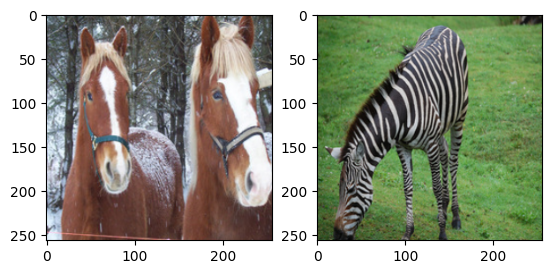

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow((horses[0].permute(1, 2, 0) + 1) / 2)
ax[1].imshow((zebras[0].permute(1, 2, 0) + 1) / 2)
plt.show()

**Models**

In this case both generators and discriminators have the same architecture (h_channels=z_channels)

In [ ]:
# Encoder (downsampler) and Decoder (upsampler)

class Downsample(nn.Module):
  def  __init__(self, input_channels, filters, kernel_size, apply_norm=True):
    super().__init__()

    self.conv = nn.Conv2d(input_channels, filters, kernel_size, stride=2, padding=1, bias=False)

    if apply_norm:
      self.insnorm = nn.InstanceNorm2d(filters)
    self.apply_norm = apply_norm

    self.activation = nn.LeakyReLU(0.3)

  def forward(self, x):
    x = self.conv(x)
    if self.apply_norm:
      x = self.insnorm(x)
    x = self.activation(x)

    return x


class Upsample(nn.Module):
  def  __init__(self, input_channels, filters, kernel_size, use_dropout=False):
    super().__init__()

    self.conv = nn.ConvTranspose2d(input_channels, filters, kernel_size, stride=2, padding=1, bias=False)
    self.insnorm = nn.InstanceNorm2d(filters)

    if use_dropout:
      self.dropout = nn.Dropout(0.5)
    self.use_dropout = use_dropout

    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.conv(x)
    x = self.insnorm(x)
    if self.use_dropout:
      x = self.dropout(x)
    x = self.activation(x)

    return x

**``Let x: horses, y: zebras``**

In [ ]:
class Generator(nn.Module):
  def __init__(self, input_channels, output_channels):
    super().__init__()

    self.down_stack = nn.ModuleList([
        Downsample(input_channels, 64, 4, apply_norm=False),
        Downsample(64, 128, 4),
        Downsample(128, 256, 4),
        Downsample(256, 512, 4),
        Downsample(512, 512, 4),
        Downsample(512, 512, 4),
        Downsample(512, 512, 4) #bottleneck (batch_size, 512, 2, 2)
    ])

    self.up_stack = nn.ModuleList([
        Upsample(512, 512, 4, use_dropout=True),
        Upsample(512+512, 512, 4, use_dropout=True),
        Upsample(512+512, 512, 4, use_dropout=True),
        Upsample(512+512, 256, 4),
        Upsample(256+256, 128, 4),
        Upsample(128+128, 64, 4),
    ])

    self.conv = nn.ConvTranspose2d(64+64, output_channels, 4, stride=2, padding=1)
    self.activation = nn.Tanh()

  def forward(self, x):

    skips = []
    for down in self.down_stack:
      x = down(x)
      skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(self.up_stack, skips):
      x = up(x)
      x = torch.cat([x, skip], dim=1)

    x = self.conv(x)
    x = self.activation(x)

    return x

In [ ]:
generator_xy = Generator(h_channels, z_channels).to(device)
generator_yx = Generator(z_channels, h_channels).to(device)

summary(generator_xy, (h_channels, original_shape, original_shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,072
         LeakyReLU-2         [-1, 64, 128, 128]               0
        Downsample-3         [-1, 64, 128, 128]               0
            Conv2d-4          [-1, 128, 64, 64]         131,072
    InstanceNorm2d-5          [-1, 128, 64, 64]               0
         LeakyReLU-6          [-1, 128, 64, 64]               0
        Downsample-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 256, 32, 32]         524,288
    InstanceNorm2d-9          [-1, 256, 32, 32]               0
        LeakyReLU-10          [-1, 256, 32, 32]               0
       Downsample-11          [-1, 256, 32, 32]               0
           Conv2d-12          [-1, 512, 16, 16]       2,097,152
   InstanceNorm2d-13          [-1, 512, 16, 16]               0
        LeakyReLU-14          [-1, 512,

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, channels):
    super().__init__()

    self.model = nn.Sequential(
       Downsample(channels, 64, 4, apply_norm=False),
       Downsample(64, 128, 4),
       Downsample(128, 256, 4),
       nn.ZeroPad2d(padding=1),
       nn.Conv2d(256, 512, 4, stride=1, bias=False),
       nn.InstanceNorm2d(512),
       nn.LeakyReLU(0.3),
       nn.ZeroPad2d(padding=1),
       nn.Conv2d(512, 1, 4, stride=1),
    )

  def forward(self, x):
    return self.model(x)

In [ ]:
discriminator_x = Discriminator(h_channels).to(device)
discriminator_y = Discriminator(z_channels).to(device)

summary(discriminator_x, (h_channels, original_shape, original_shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,072
         LeakyReLU-2         [-1, 64, 128, 128]               0
        Downsample-3         [-1, 64, 128, 128]               0
            Conv2d-4          [-1, 128, 64, 64]         131,072
    InstanceNorm2d-5          [-1, 128, 64, 64]               0
         LeakyReLU-6          [-1, 128, 64, 64]               0
        Downsample-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 256, 32, 32]         524,288
    InstanceNorm2d-9          [-1, 256, 32, 32]               0
        LeakyReLU-10          [-1, 256, 32, 32]               0
       Downsample-11          [-1, 256, 32, 32]               0
        ZeroPad2d-12          [-1, 256, 34, 34]               0
           Conv2d-13          [-1, 512, 31, 31]       2,097,152
   InstanceNorm2d-14          [-1, 512,

**CycleGAN Training**

In [ ]:
gen_optimizer = torch.optim.Adam(list(generator_xy.parameters()) + list(generator_yx.parameters()), lr=lr, betas=betas)
gen_yx_optimizer = torch.optim.Adam(generator_yx.parameters(), lr=lr, betas=betas)
disc_x_optimizer = torch.optim.Adam(discriminator_x.parameters(), lr=lr, betas=betas)
disc_y_optimizer = torch.optim.Adam(discriminator_y.parameters(), lr=lr, betas=betas)

adversarial_criterion = nn.BCEWithLogitsLoss()
identity_criterion = nn.L1Loss()
cycle_criterion = nn.L1Loss()

#LAMBDA = 10
lambda_identity = 0.1
lambda_cycle = 10

In [ ]:
def weights_init(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m, nn.BatchNorm2d):
    nn.init.normal_(m.weight, 0.0, 0.02)
    nn.init.constant_(m.bias, 0)

Checkpointing is crucial for lengthy training processes; 'load_state_dict' ensures continuity of progress in PyTorch.

In [ ]:
pretrained = True #Change according to previous training
checkpoint_folder = "/content/drive/MyDrive/checkpoints/Pytorch_CycleGAN/"

if pretrained:
  last_epoch = 80 #Put the last epoch of the pretrained model
  loaded_state = torch.load(os.path.join(checkpoint_folder, f"epoch_{last_epoch}.pth"))

  generator_xy.load_state_dict(loaded_state["generator_xy"])
  generator_yx.load_state_dict(loaded_state["generator_yx"])
  gen_optimizer.load_state_dict(loaded_state["gen_optimizer"])

  discriminator_x.load_state_dict(loaded_state["discriminator_x"])
  disc_x_optimizer.load_state_dict(loaded_state["disc_x_optimizer"])
  discriminator_y.load_state_dict(loaded_state["discriminator_y"])
  disc_y_optimizer.load_state_dict(loaded_state["disc_y_optimizer"])

  history = pd.read_csv(os.path.join(checkpoint_folder, f"losses_epoch_{last_epoch}.csv"))
  history = history.to_dict(orient="list")

else:
  last_epoch = 0

  os.makedirs(checkpoint_folder, exist_ok=True)
  generator_xy = generator_xy.apply(weights_init)
  generator_yx = generator_yx.apply(weights_init)
  discriminator_x = discriminator_x.apply(weights_init)
  discriminator_y = discriminator_y.apply(weights_init)

  history = {"gen_loss":[], "disc_x_loss":[], "disc_y_loss":[]}

In [ ]:
# CycleGAN losses

def get_disc_loss(real_images, fake_images, discriminator):
  fake_out = discriminator(fake_images.detach())
  real_out = discriminator(real_images)
  fake_loss = adversarial_criterion(fake_out, torch.zeros_like(fake_out))
  real_loss = adversarial_criterion(real_out, torch.ones_like(real_out))
  disc_loss = (fake_loss + real_loss) / 2
  return disc_loss


def get_gen_loss(real_x, real_y):

  def get_adversarial_loss(real_x, generator_xy, discriminator_y):
    fake_y = generator_xy(real_x)
    fake_out_y = discriminator_y(fake_y)
    adversarial_loss = adversarial_criterion(fake_out_y, torch.ones_like(fake_out_y))
    return adversarial_loss, fake_y

  def get_cycle_loss(real_x, fake_y, generator_yx):
    fake_x = generator_yx(fake_y)
    cycle_loss = cycle_criterion(fake_x, real_x)
    return cycle_loss

  def get_identity_loss(real_x, generator_yx):
    fake_x = generator_yx(real_x)
    identity_loss = identity_criterion(fake_x, real_x)
    return identity_loss

  adversarial_loss_xy, fake_y = get_adversarial_loss(real_x, generator_xy, discriminator_y)
  adversarial_loss_yx, fake_x = get_adversarial_loss(real_y, generator_yx, discriminator_x)

  cycle_loss_yx = get_cycle_loss(real_x, fake_y, generator_yx)
  cycle_loss_xy = get_cycle_loss(real_y, fake_x, generator_xy)

  identity_loss_xy = get_identity_loss(real_y, generator_xy)
  identity_loss_yx = get_identity_loss(real_x, generator_yx)

  gen_loss = (adversarial_loss_xy + adversarial_loss_yx +
              lambda_identity * (identity_loss_xy + identity_loss_yx) +
              lambda_cycle * (cycle_loss_xy + cycle_loss_yx))

  return gen_loss, fake_x, fake_y

In [ ]:
# Function to display images

def show_images(real_x, fake_y, num_examples, random=True, names=["", ""], cmap=None):

  real_x= real_x.cpu()
  fake_y = fake_y.cpu()

  # Denormalization
  real_x = (real_x + 1) / 2
  fake_y = (fake_y + 1) / 2

  indices = np.arange(len(real_x))
  if random:
    np.random.shuffle(indices)

  if num_examples == 1:
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(real_x[indices[0]].permute(1, 2, 0), cmap=cmap)
    ax[0].axis("off")
    ax[0].set_title(names[0], fontsize=10)
    ax[1].imshow(fake_y[indices[0]].permute(1, 2, 0), cmap=cmap)
    ax[1].axis("off")
    ax[1].set_title(f"Generated {names[1]}", fontsize=10)

  else:
    fig, ax = plt.subplots(num_examples, 2, figsize=(8, 4*num_examples))
    for i in range(num_examples):
      ax[i, 0].imshow(real_x[indices[i]].permute(1, 2, 0), cmap=cmap)
      ax[i, 0].axis("off")
      ax[i, 1].imshow(fake_y[indices[i]].permute(1, 2, 0), cmap=cmap)
      ax[i, 1].axis("off")
    ax[0, 0].set_title(names[0], fontsize=10)
    ax[0, 1].set_title(f"Generated {names[1]}", fontsize=10)

  plt.show()

In [ ]:
def train_model(epochs, history=history, num_examples=1, save_model=True, display_wait=False):

  for epoch in range(epochs):
    gen_loss_list, disc_x_loss_list, disc_y_loss_list = [], [], []
    current_epoch = last_epoch + epoch + 1

    with tqdm(train_dataset) as pbar:
      pbar.set_description(f"[Epoch: {current_epoch}/{last_epoch + epochs}]")
      for real_x, real_y in pbar:
        real_x = real_x.to(device)
        real_y = real_y.to(device)

        # Update horse discriminator
        disc_x_optimizer.zero_grad()
        with torch.no_grad():
          fake_x = generator_yx(real_y)
        disc_x_loss = get_disc_loss(real_x, fake_x, discriminator_x)

        disc_x_loss.backward(retain_graph=True)
        disc_x_optimizer.step()

        # Update zebra discriminator
        disc_y_optimizer.zero_grad()
        with torch.no_grad():
          fake_y = generator_xy(real_x)
        disc_y_loss = get_disc_loss(real_y, fake_y, discriminator_y)

        disc_y_loss.backward(retain_graph=True)
        disc_y_optimizer.step()

        # Update generator
        gen_optimizer.zero_grad()
        gen_loss, fake_x, fake_y = get_gen_loss(real_x, real_y)

        gen_loss.backward()
        gen_optimizer.step()

        gen_loss_list.append(gen_loss.item())
        disc_x_loss_list.append(disc_x_loss.item())
        disc_y_loss_list.append(disc_y_loss.item())
        pbar.set_postfix({"gen_loss":gen_loss.item(), "disc_x_loss":disc_x_loss.item(), "disc_y_loss":disc_y_loss.item()})

    gen_loss_mean = np.mean(gen_loss_list)
    disc_x_loss_mean = np.mean(disc_x_loss_list)
    disc_y_loss_mean = np.mean(disc_y_loss_list)
    history["gen_loss"].append(gen_loss_mean)
    history["disc_x_loss"].append(disc_x_loss_mean)
    history["disc_y_loss"].append(disc_y_loss_mean)

    display.clear_output(wait=display_wait)
    print(f"Epoch {current_epoch}, Generator(U-Net)Loss: {gen_loss_mean}, HorseDiscLoss: {disc_x_loss_mean}, ZebraDiscLoss: {disc_y_loss_mean}")
    show_images(real_x, fake_y.detach(), num_examples, names=["Horse", "Zebra"])
    show_images(real_y, fake_x.detach(), num_examples, names=["Zebra", "Horse"])

    if save_model and (current_epoch % 10 == 0):
      torch.save({"generator_xy": generator_xy.state_dict(),
                  "generator_yx": generator_yx.state_dict(),
                  "gen_optimizer": gen_optimizer.state_dict(),
                  "discriminator_x": discriminator_x.state_dict(),
                  "disc_x_optimizer": disc_x_optimizer.state_dict(),
                  "discriminator_y": discriminator_y.state_dict(),
                  "disc_y_optimizer": disc_y_optimizer.state_dict()},
                 os.path.join(checkpoint_folder, f"epoch_{current_epoch}.pth"))

      df = pd.DataFrame(history)
      df.to_csv(os.path.join(checkpoint_folder, f"losses_epoch_{current_epoch}.csv"), index=False)

  return history

In [ ]:
epochs = 20

Epoch 100, Generator(U-Net)Loss: 3.8136981352051693, HorseDiscLoss: 0.6042510284416711, ZebraDiscLoss: 0.4789514212465998


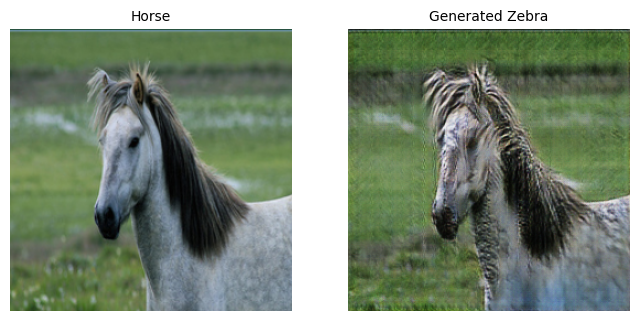

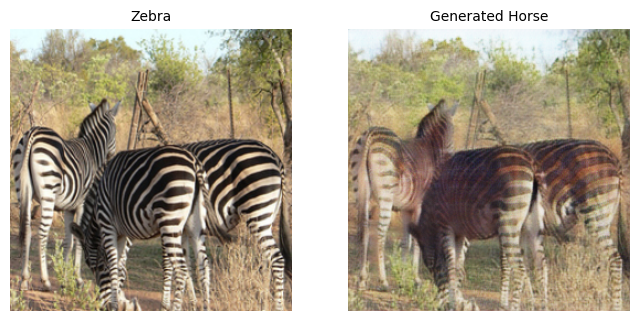

In [ ]:
# Each epoch on the colab gpu takes approx. 3 min

history = train_model(epochs=epochs)

In [10]:
def plot_metrics(history, renderer=None, epochs = last_epoch + epochs + 1):
  gen_losses = history["gen_loss"]
  disc_x_losses = history["disc_x_loss"]
  disc_y_losses = history["disc_y_loss"]
  list_epochs = np.arange(1, epochs+1)

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=gen_losses, name="Generator Loss", line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=disc_x_losses, name="HorseDiscLoss", line=dict(color="red", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=disc_y_losses, name="ZebraDiscLoss", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text="Loss")
  fig.update_layout(title=f"<b>Evolution of Loss across Epochs</b>",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)
  fig.show(renderer)

In [13]:
# Interactive graphic
plot_metrics(history)

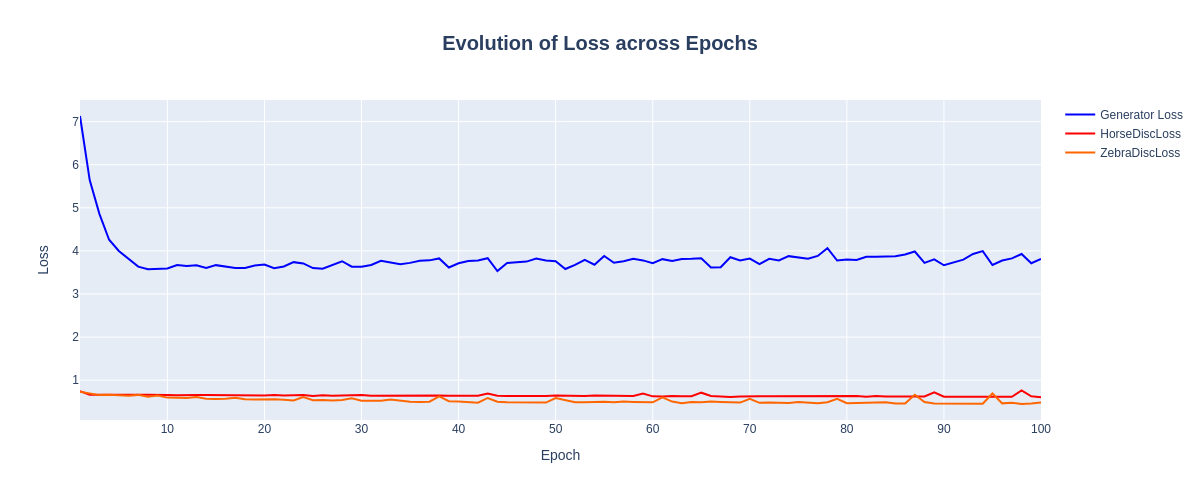

In [14]:
# Image for GitHub
plot_metrics(history, renderer="png")

**Examples with the training dataset**

In [ ]:
train_horse, train_zebra = [], []
for horse, zebra in train_data:
  train_horse.append(horse)
  train_zebra.append(zebra)

train_horse = torch.stack(train_horse)
train_zebra = torch.stack(train_zebra)

train_horse.shape, train_zebra.shape

(torch.Size([1067, 3, 256, 256]), torch.Size([1067, 3, 256, 256]))

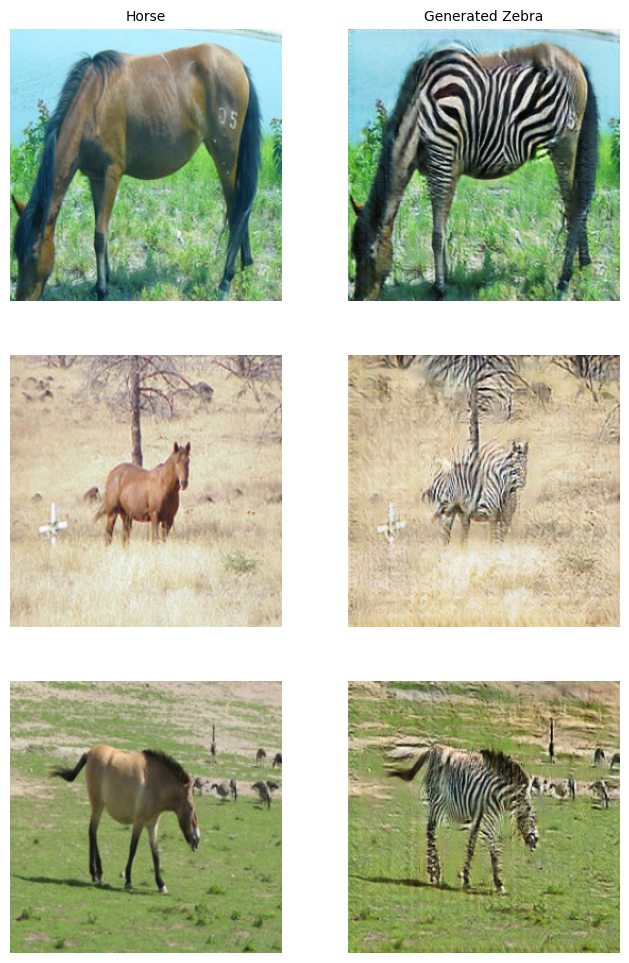

In [ ]:
list_indices = [77, 159, 225]
train_horse = train_horse[list_indices]
fake_train_zebra = generator_xy(train_horse.to(device)).detach()

show_images(train_horse, fake_train_zebra, num_examples=len(list_indices), names=["Horse", "Zebra"])

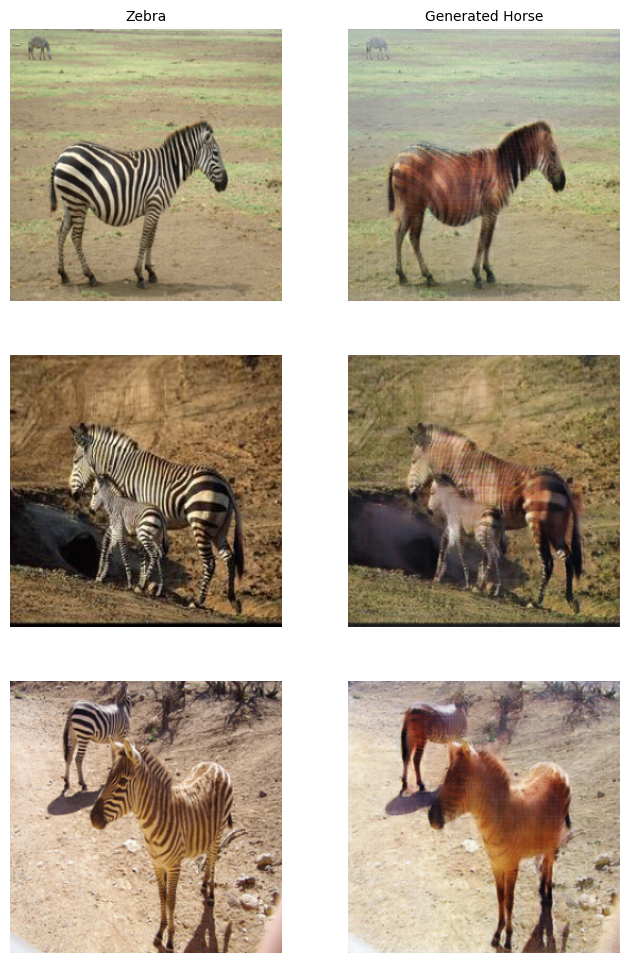

In [ ]:
list_indices = [2, 10, 81]
train_zebra = train_zebra[list_indices]
fake_train_horse = generator_yx(train_zebra.to(device)).detach()

show_images(train_zebra, fake_train_horse, num_examples=len(list_indices), names=["Zebra", "Horse"])

**Examples with the testing dataset**

In [ ]:
test_horse, test_zebra = [], []
for horse, zebra in test_dataset:
  test_horse.append(horse)
  test_zebra.append(zebra)

test_horse = torch.stack(test_horse)
test_zebra = torch.stack(test_zebra)

test_horse.shape, test_zebra.shape

(torch.Size([120, 3, 256, 256]), torch.Size([120, 3, 256, 256]))

In [ ]:
fake_test_zebra = generator_xy(test_horse.to(device)).detach()
fake_test_horse = generator_yx(test_zebra.to(device)).detach()

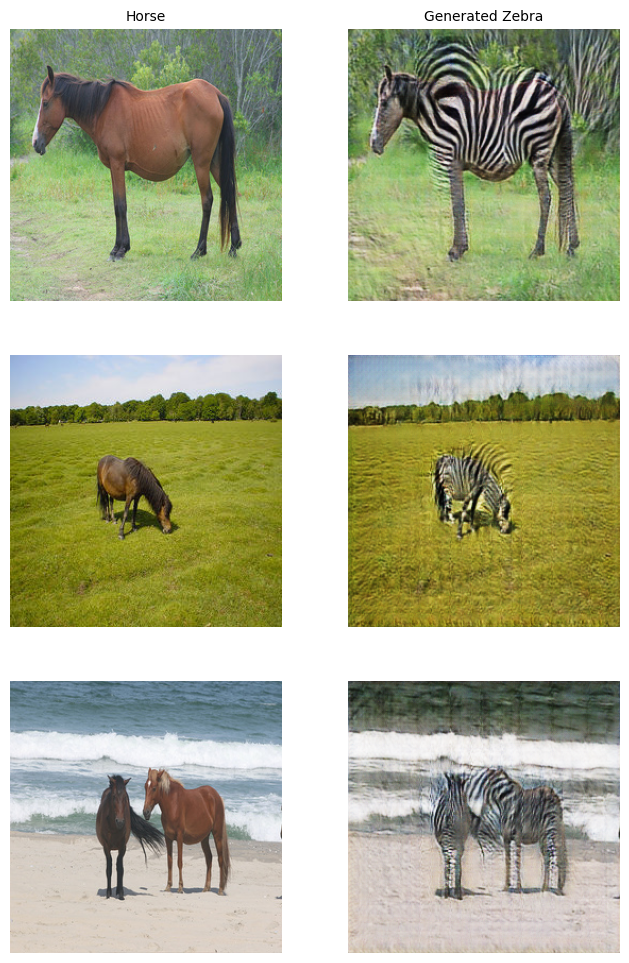

In [ ]:
num_examples = 3
list_indices = [68, 84, 105]
show_images(test_horse[list_indices], fake_test_zebra[list_indices], num_examples=num_examples, names=["Horse", "Zebra"])

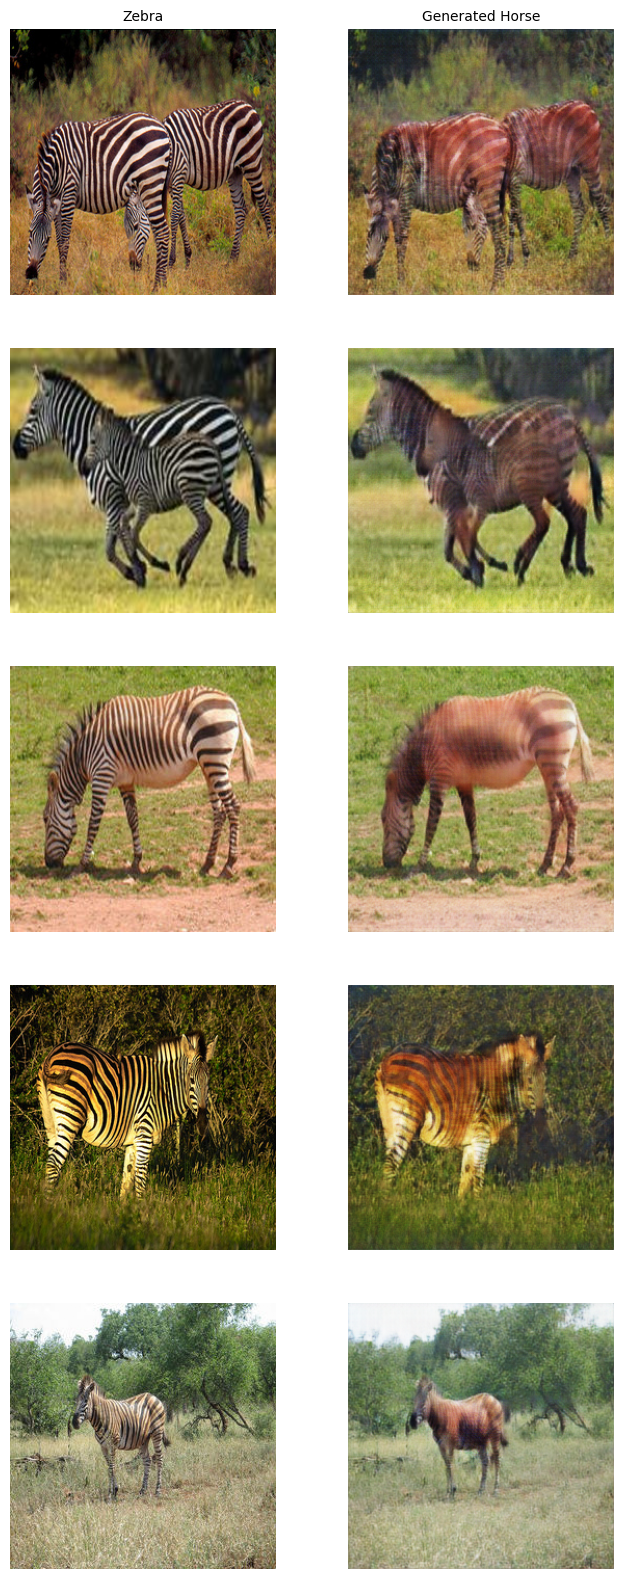

In [ ]:
num_examples = 5
list_indices = [0, 28, 40,59, 92]
show_images(test_zebra[list_indices], fake_test_horse[list_indices], num_examples=num_examples, names=["Zebra", "Horse"])